
# Обучение-валидация-тест в АБ-тестировании и другие особенности

In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from statsmodels.stats.proportion import proportion_confint

sns.set(palette='Set2', style='whitegrid', font_scale=1.3)

Подобно ML в AB-тестах тоже есть обучение, валидация и тест. Разберем каждый из них в обратном порядке &mdash; сначала тестирование, потом валидацию, и затем обучение.

## 1. Тестирование

На этом этапе просто применяем статистический критерий к данным

In [ ]:
x, y = sps.norm.rvs(size=(2, 100))
y += 0.2

sps.ttest_ind(x, y)

TtestResult(statistic=-0.9067066744201827, pvalue=0.3656640462085752, df=198.0)

In [ ]:
sps.ttest_ind(x, y, alternative='greater')

TtestResult(statistic=-0.9067066744201827, pvalue=0.8171679768957124, df=198.0)

In [ ]:
sps.ttest_ind(x, y, alternative='less')

TtestResult(statistic=-0.9067066744201827, pvalue=0.1828320231042876, df=198.0)

### 1.1 Почему обычно используют t-test

Сгенерируем выборки из смеси экспоненциальных распределений. Основная часть объектов будет иметь небольшое среднее и лишь некоторые из них &mdash; достаточно большое.

In [2]:
def generate_mix_expon(sample_sizes=[100, 10], scale=[1, 10]):
    ''' Генерация выборки из смеси двух экспоненциальных распределений. '''

    x1 = np.random.exponential(size=sample_sizes[0], scale=scale[0])
    x2 = np.random.exponential(size=sample_sizes[1], scale=scale[1])
    return np.concatenate([x1, x2])

Во второй выборке немного увеличим среднее первой компоненты и сильно уменьшим среднее второй

In [3]:
x = generate_mix_expon(sample_sizes=[1000, 100], scale=[1, 15])
y = generate_mix_expon(sample_sizes=[1000, 100], scale=[1.2, 10])

В результате общее среднее упало

In [24]:
y.mean() - x.mean()

-0.22043713794074993

t-test не отвергает гипотезу об отсутствии эффекта против альтернативы *положительного* эффекта

In [5]:
sps.ttest_ind(x, y, alternative='less')

TtestResult(statistic=0.9983686806722489, pvalue=0.8408947453070096, df=2198.0)

Не редко аналитики начинают логарифмировать метрики, так делать не стоит, это ее исказит. Теперь t-test отвергает основную гипотезу в пользу наличия положительного эффекта

In [6]:
sps.ttest_ind(np.log(x), np.log(y), alternative='less')

TtestResult(statistic=-1.9742778741172462, pvalue=0.024237583507086692, df=2198.0)

Критерий Манна-Уитни также отвергает в пользу наличия положительного эффекта

In [7]:
sps.mannwhitneyu(x, y, alternative='less')

MannwhitneyuResult(statistic=569196.0, pvalue=0.008123260406525026)

## 2. Валидация

Этот этап мы тоже хорошо знаем, это просто AA-тест.

Валидацию можно проводить, используя
* искусственные данные
* исторические данные

In [36]:
def draw_interval(
    real_alpha, left_alpha, right_alpha,
    alpha=0.05, figsize=(7, 2)
):
    '''
    Отрисовка интервала для реального уровня значимости
    real_alpha -- оценка уровня значимости
    left_alpha, right_alpha -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    figsize -- размер фигуры matplotlib
    '''

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(6, 2))
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_alpha, right_alpha], [0.15]*2, [-0.15]*2,
            color='green', alpha=0.6
        )
        plt.scatter(real_alpha, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_alpha)-1e-3, max(alpha, right_alpha)+1e-3))
        plt.title(
            f'Доля отвержений = {100*real_alpha:.2f}%, '
            f'интервал ({100*left_alpha:.2f}%, {100*right_alpha:.2f}%)'
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()

In [37]:
def calculate_real_alpha(n_errors, n_iter):
    '''
    Оценка реального уровня значимости и его дов. интервала.

    Аргументы:
    n_errors -- количество ошибок в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    real_alpha -- оценка реального уровня значимости
    left_alpha, right_alpha -- границы соотв. дов. интервала
    '''

    real_alpha = n_errors / n_iter
    left_alpha, right_alpha = proportion_confint(n_errors, n_iter, method='wilson')

    return real_alpha, left_alpha, right_alpha

In [38]:
def AA_test(
    test, generate_sample_x, generate_sample_y=None,
    n_iter=10000, sample_size=1000, alpha=0.05
):
    '''
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- теоретический уровень значимости
    '''

    if generate_sample_y is None:
        generate_sample_y = generate_sample_x

    n_errors = 0  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        x = generate_sample_x(size=sample_size)
        y = generate_sample_y(size=sample_size)
        n_errors += test(x, y)

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

Установим параметры экспериментов

In [39]:
alpha = 0.05  # Теоретический уровень значимости
sample_size = 1_000  # Размер выборок
n_iter = 50_00  # Количество итераций валидации

Простые примеры

100%|██████████| 5000/5000 [00:05<00:00, 986.38it/s] 


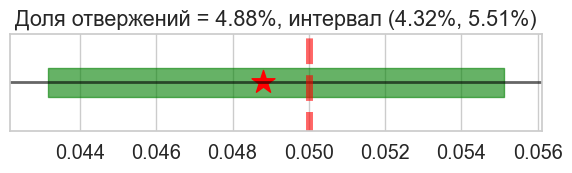

In [40]:
AA_test(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    generate_sample_x=np.random.normal,
    sample_size=sample_size,
    n_iter=n_iter,
)

100%|██████████| 5000/5000 [00:04<00:00, 1031.13it/s]


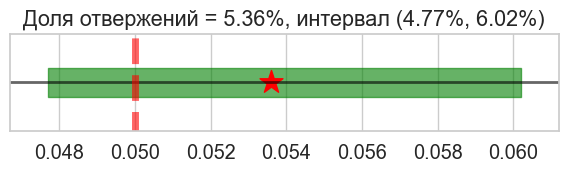

In [41]:
AA_test(
    test=lambda x, y: sps.ttest_ind(x, y, alternative='greater')[1] < alpha,
    generate_sample_x=np.random.normal,
    sample_size=sample_size,
    n_iter=n_iter,
)

### 2.1 Почему нельзя смотреть на тестовые данные и принимать решение о виде критерия

Посмотрим на распределение разности средних

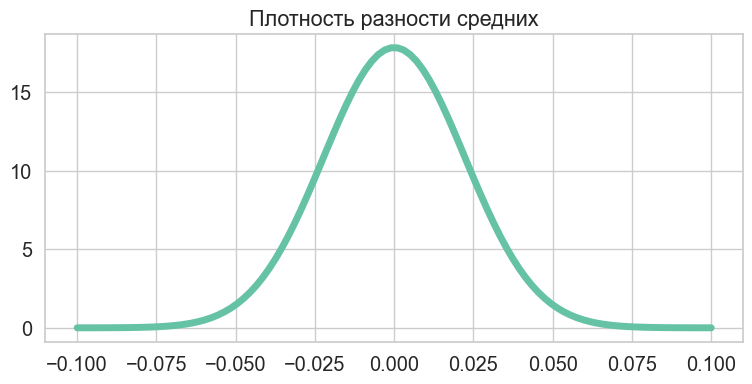

In [42]:
grid = np.linspace(-0.1, 0.1, 100)
density = sps.norm.pdf(grid, scale=1/np.sqrt(2*sample_size))

plt.figure(figsize=(9, 4))
plt.plot(grid, density, lw=5)
plt.title('Плотность разности средних');

Будем пользоваться односторонним критерием, если разница средних большая, иначе &mdash; двусторонним

In [43]:
def Panenko_test(x, y, threshold=0.07, alpha=0.05):
    '''
    Критерий имени Семена Паненко.

    x, y -- выборки
    threshold -- порог разности средних, начиная с которого пользуемся односторонним критерием
    alpha -- теоретический уровень значимости
    '''

    mean_x, mean_y = x.mean(), y.mean()

    if mean_x > mean_y + threshold:
        return sps.ttest_ind(x, y, alternative='greater')[1] < alpha
    elif mean_x < mean_y - threshold:
        return sps.ttest_ind(x, y, alternative='less')[1] < alpha
    else:
        return sps.ttest_ind(x, y, alternative='two-sided')[1] < alpha

Такая процедура увеличивает ошибку 1 рода в 2 раза.

100%|██████████| 50000/50000 [00:46<00:00, 1072.90it/s]


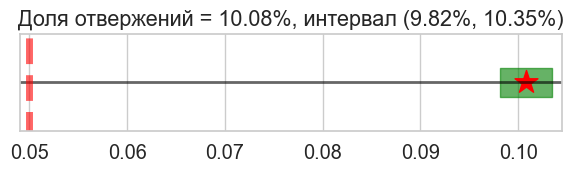

In [33]:
AA_test(
    test=Panenko_test,
    generate_sample_x=np.random.normal,
    n_iter=n_iter,
)

### 2.2 Почему нельзя удалять выбросы на тех данных, на которых тестируем

Известно, что t-test неустойчив к выбросам. Давайте уберем выбросы в каждой из выборок по 1% слева и справа.

In [75]:
def cut_test(x, y, q=0.01, alpha=0.05):
    '''
    Критерий, который удаляет выбросы и применяет ttest.

    x, y -- выборки
    q -- доля выбросов с каждой стороны
    alpha -- теоретический уровень значимости
    '''

    x = x[x <= np.percentile(x, 100*(1-q))]
    x = x[x >= np.percentile(x, 100*q)]
    y = y[y <= np.percentile(x, 100*(1-q))]
    y = y[y >= np.percentile(x, 100*q)]

    return sps.ttest_ind(x, y, alternative='two-sided')[1] < alpha

Может получиться более менее

100%|██████████| 5000/5000 [00:09<00:00, 552.27it/s]


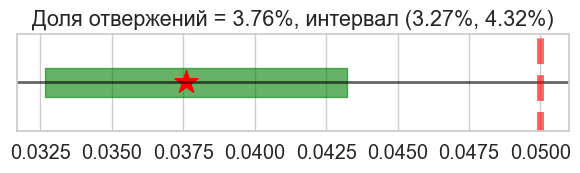

In [76]:
AA_test(
    test=cut_test,
    generate_sample_x=lambda size: np.random.standard_t(df=5, size=size),
    n_iter=n_iter,
)

А может и плохо. (Почему?)

100%|██████████| 5000/5000 [00:07<00:00, 629.07it/s]


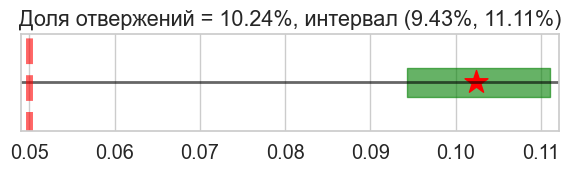

In [77]:
AA_test(
    test=cut_test,
    generate_sample_x=np.random.exponential,
    n_iter=n_iter,
)

Тест `cut_test` не корректно реализован. Верхние и нижние перцентили считаются по разному усеченной выборке x.
Определим квантили до усечения

In [92]:
def cut_test_corr(x, y, q=0.01, alpha=0.05):
    '''
    Критерий, который удаляет выбросы и применяет ttest.

    x, y -- выборки
    q -- доля выбросов с каждой стороны
    alpha -- теоретический уровень значимости
    '''
    min_sample, max_sample = np.percentile(x, 100*(q)) ,np.percentile(x, 100*(1-q))

    x = x[(x <= max_sample) & (x >= min_sample)]
    y = y[(y <= max_sample) & (y >= min_sample)]

    return sps.ttest_ind(x, y, alternative='two-sided')[1] < alpha

100%|██████████| 5000/5000 [00:07<00:00, 677.89it/s]


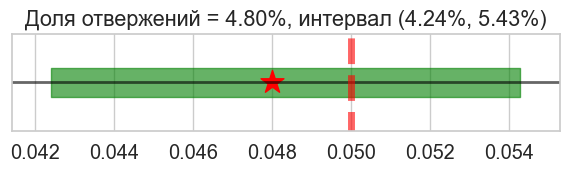

In [93]:
AA_test(
    test=cut_test_corr,
    generate_sample_x=np.random.exponential,
    n_iter=n_iter,
)

Тест корректен. Также рассчитаем квантили по обоим выборкам для уменьшения погрешности расчетов квантилей

In [90]:
def cut_test_share(x, y, q=0.01, alpha=0.05):
    '''
    Критерий, который удаляет выбросы и применяет ttest.

    x, y -- выборки
    q -- доля выбросов с каждой стороны
    alpha -- теоретический уровень значимости
    '''
    share = np.concatenate([x,y])
    min_sample, max_sample = np.percentile(share, 100*(q)) ,np.percentile(share, 100*(1-q))

    x = x[(x <= max_sample) & (x >= min_sample)]
    y = y[(y <= max_sample) & (y >= min_sample)]
    
    return sps.ttest_ind(x, y, alternative='two-sided')[1] < alpha

100%|██████████| 5000/5000 [00:07<00:00, 644.04it/s] 


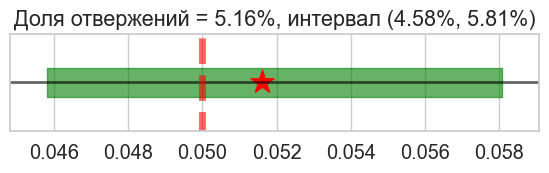

In [91]:
AA_test(
    test=cut_test_share,
    generate_sample_x=np.random.exponential,
    n_iter=n_iter,
)

На всякий случай убедимся, что простой t-test адекватно обрабатывает выборки из экспоненциального распределения

100%|██████████| 5000/5000 [00:05<00:00, 877.18it/s] 


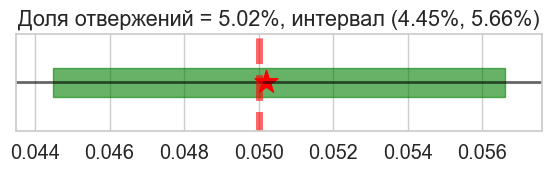

In [94]:
AA_test(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    generate_sample_x=np.random.exponential,
    n_iter=n_iter,
)

## 3. Обучение

На этом этапе мы подготавливаем выборки до эксперимента на основе исторических данных.

В частности,
* оценка дисперсии для MDE
* удаление выбросов
* подбор похожих групп
* более продвинутые вещи, будем изучать позже, в частности, применение ML-моделей

Валидация должна происходить многократным семплированием обучающих и тестовых данных. Например, при валидации на исторических данных нужно многократно выбирать:
* точку старта, за которой сначала идет предэкспериментальный (обучающий) период, затем &mdash; сам экспериментальный период
* А и Б группы.
Если обучение заключается в удалении выбросов, то на каждой итерации валидации необходимо удалять выбросы на своем предэкспериментальном периоде.



### 3.1 Попробуем фильтровать выбросы по историческим данным

In [95]:
def generate_train_test_sample(generate_sample, sample_size=1000, scale_factor=0.1):
    '''
    Генерация всей совокупности объектов

    generate_sample -- функция генерации выборки
    sample_size -- размер выборки
    scale_factor -- доля увеличения дисперсии на экспериментальном периоде

    Возвращает данные за предэкспериментальный и экспериментальный периоды.
    '''

    prepilot = generate_sample(size=sample_size)
    pilot = prepilot + np.random.normal(
        size=sample_size,
        scale=prepilot.std() * scale_factor
    )

    return prepilot, pilot

In [68]:
def filter_outliers(x_prepilot, y_prepilot, x_pilot, y_pilot, q=0.99):
    '''
    Фильтрация экспериментальных данных на основе предэкспериментального периода.

    x_prepilot, y_prepilot -- данные предэкспериментального периода
    x, y -- данные экспериментального периода
    q -- порог фильтрации данных

    Возвращает очищенные данные экспериментального периода.
    '''

    outlier_threshold = np.quantile(np.concatenate([x_prepilot, y_prepilot]), q)

    x = x_pilot[x_pilot <= outlier_threshold]
    y = y_pilot[y_pilot <= outlier_threshold]

    return x, y

In [96]:
def AA_test_trained(
    test, train, generate_sample_x, generate_sample_y=None,
    n_iter=10000, sample_size=1000, alpha=0.05
):
    '''
    Проведение серии AА-тестов на искусственных выборках с обучением.

    Аргументы:
    test -- статистический критерий
    train -- функция обучения
    generate_sample_x, generate_sample_y -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- уровень значимости
    '''

    if generate_sample_y is None:
        generate_sample_y = generate_sample_x

    n_errors = 0  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        # Генерируем данные
        x_prepilot, x = generate_train_test_sample(generate_sample_x, sample_size)
        y_prepilot, y = generate_train_test_sample(generate_sample_y, sample_size)

        # Обучаемся
        x, y = train(x_prepilot, y_prepilot, x, y)

        # Применяем критерий (тестируем)
        n_errors += test(x, y)

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

Проверим, что теперь все хорошо

100%|██████████| 5000/5000 [00:06<00:00, 726.85it/s]


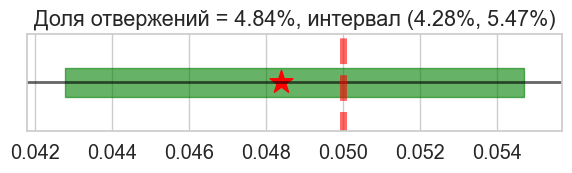

In [97]:
AA_test_trained(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    train=filter_outliers,
    generate_sample_x=np.random.exponential,
    n_iter=n_iter,
)

#### Отступление: проблема несопоставимости

Возьмем разные типы распределений с одним средним и одинаковой дисперсией

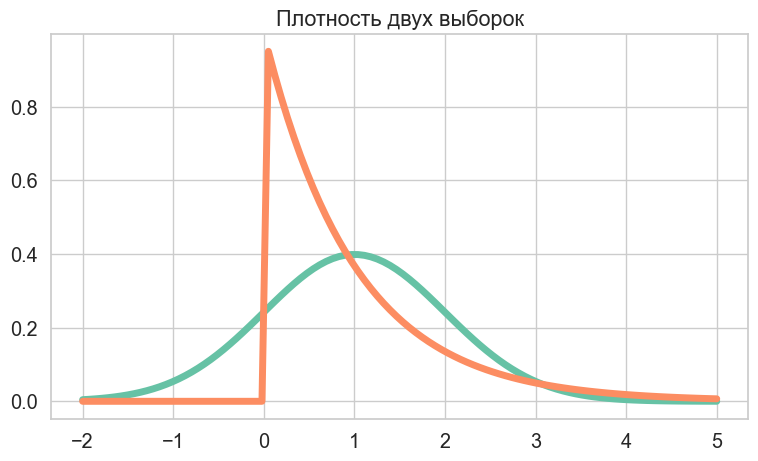

In [98]:
grid = np.linspace(-2, 5, 100)
density_x = sps.norm.pdf(grid, loc=1)
density_y = sps.expon.pdf(grid)

plt.figure(figsize=(9, 5))
plt.plot(grid, density_x, lw=5)
plt.plot(grid, density_y, lw=5);
plt.title('Плотность двух выборок');

Проверим, что обычный t-test выдает корректные результаты

100%|██████████| 5000/5000 [00:04<00:00, 1097.32it/s]


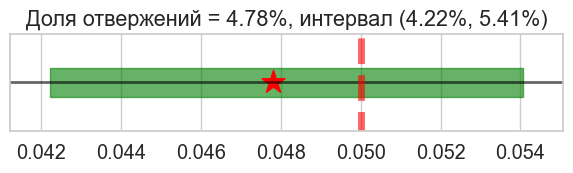

In [99]:
AA_test(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    generate_sample_x=lambda size: np.random.normal(size=size, loc=1),
    generate_sample_y=np.random.exponential,
    n_iter=n_iter,
)

Если мы попробуем убрать выбросы на экспериментальном периоде, то мы обрежем хвост экспоненциального, который вносит большой вклад в среднее, тем самым сильно его сдвинем

100%|██████████| 5000/5000 [00:09<00:00, 509.02it/s]


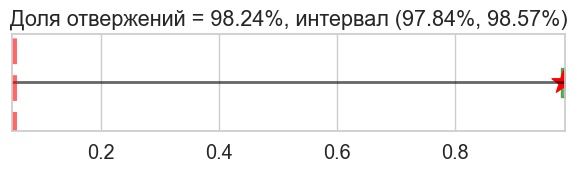

In [100]:
AA_test(
    test=cut_test,
    generate_sample_x=lambda size: np.random.normal(size=size, loc=1),
    generate_sample_y=np.random.exponential,
    n_iter=n_iter,
)

Попробуем также совместный тест

100%|██████████| 5000/5000 [00:06<00:00, 787.07it/s] 


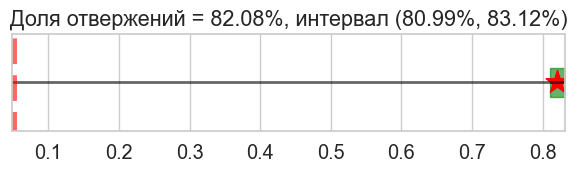

In [103]:
AA_test(
    test=cut_test_share,
    generate_sample_x=lambda size: np.random.normal(size=size, loc=1),
    generate_sample_y=np.random.exponential,
    n_iter=n_iter,
)

Но даже если выбросы обрезать "как надо", все равно может получиться плохо. Проблема в несопоставимости групп. Что делать &mdash; будем разбирать позже

100%|██████████| 5000/5000 [00:06<00:00, 738.72it/s] 


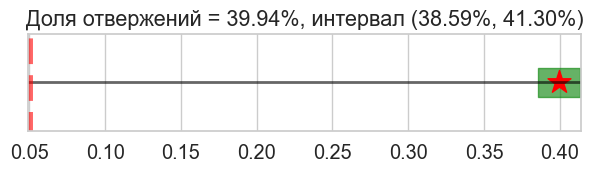

In [104]:
AA_test_trained(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    train=filter_outliers,
    generate_sample_x=lambda size: np.random.normal(size=size, loc=1),
    generate_sample_y=np.random.exponential,
    n_iter=n_iter,
)

### 3.2 Подбор похожих

Для снижения дисперсии разности средних можно выбирать группы не случайно, а на основе похожести. Например, можно выбрать одну группу случайно, а другую &mdash; по ближайшим соседям жадным образом.

In [113]:
def random_indexes(prepilot, total_size, sample_size):
    '''
    Случайный выбор индексов для двух групп.

    prepilot -- не используется, нужен для совместимости
    total_size -- общее количество данных
    sample_size -- размер выборок
    '''

    ind = np.random.choice(np.arange(total_size), size=2*sample_size, replace=False)
    a_indexes, b_indexes = ind[:sample_size], ind[sample_size:]
    return a_indexes, b_indexes

In [181]:
import scipy
def nearest_object_indexes(prepilot, total_size, sample_size):
    '''
    Одну группу выбираем случайно, другую - жадным образом
    на основе похожести по историческим данным

    prepilot -- выборка пилота
    total_size -- общее количество данных
    sample_size -- размер выборок

    Returns:
        b_indexes - test_group_indexes
        a_indexes - similar_group_indexes
    '''
    # Выбираем тестовую группу
    b_indexes = np.random.choice(np.arange(total_size), size=sample_size, replace=False)
    mask = np.ones(total_size, dtype=bool)
    mask[b_indexes] = False

    # Выделяем индексы остальных объектов
    other_indexes = np.arange(total_size)[mask]
    # Считаем попарные расстояния между выбранными и остальными

    cost = np.abs(prepilot[b_indexes, None] - prepilot[other_indexes])
    indexes, _ = scipy.optimize.linear_sum_assignment(cost)
 
    a_indexes = other_indexes[indexes]
    
    return a_indexes, b_indexes

In [137]:
def AA_test_selection(
    test, generate_sample, generate_indexes,
    n_iter=10000, sample_size=100, alpha=0.05, effect=0
):
    '''
    Проведение серии AА-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_sample -- функция для семплирования общего объема данных
    generate_indexes -- функции для семплирования индексов выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    alpha -- уровень значимости
    effect -- размер эффекта, который добавляем к одной из групп
    '''

    # Генерируем общий объем данных
    total_size = 20*sample_size
    prepilot, pilot = generate_train_test_sample(
        generate_sample=generate_sample,
        sample_size=total_size,
        scale_factor=0.3
    )

    n_errors = 0  # количество отвержений H_0
    diffs = []  # разность средних

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        # Семплируем индексы групп
        a_indexes, b_indexes = generate_indexes(prepilot, total_size, sample_size)

        # Определяем группы
        x = pilot[a_indexes]
        y = pilot[b_indexes] + effect

        # Тестируем
        n_errors += test(x, y)

        # Сохраняем разность средних
        diffs.append(x.mean() - y.mean())

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

    return diffs

Эффекты от подбора похожих групп сильнее проявляются на не сильно больших выборках, поэтому уменьшим размер выборок

In [118]:
sample_size = 100

Проведем валидация при случайном выборе групп

100%|██████████| 5000/5000 [00:02<00:00, 1754.03it/s]


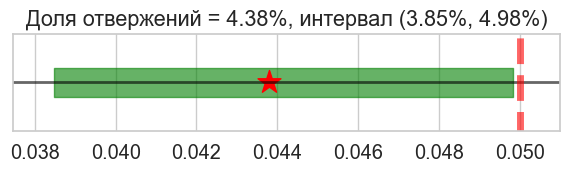

In [139]:
diffs_random = AA_test_selection(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    generate_sample=np.random.exponential,
    generate_indexes=random_indexes,
    n_iter=n_iter,
    sample_size=sample_size
)

Теперь будем выбирать похожие

100%|██████████| 5000/5000 [00:19<00:00, 250.08it/s]


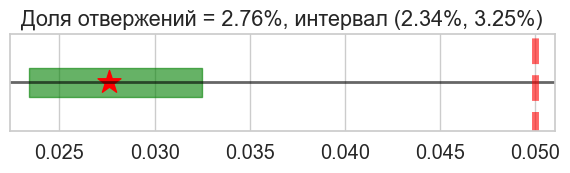

In [183]:
diffs_nearest = AA_test_selection(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    generate_sample=np.random.exponential,
    generate_indexes=nearest_object_indexes,
    n_iter=n_iter,
    sample_size=sample_size
)

Можем также нарисовать оценку плотности разности и увидеть, что в случае похожих групп дисперсия разности средних сильно меньше. Следовательно, мощность должна быть выше в случае похожих групп

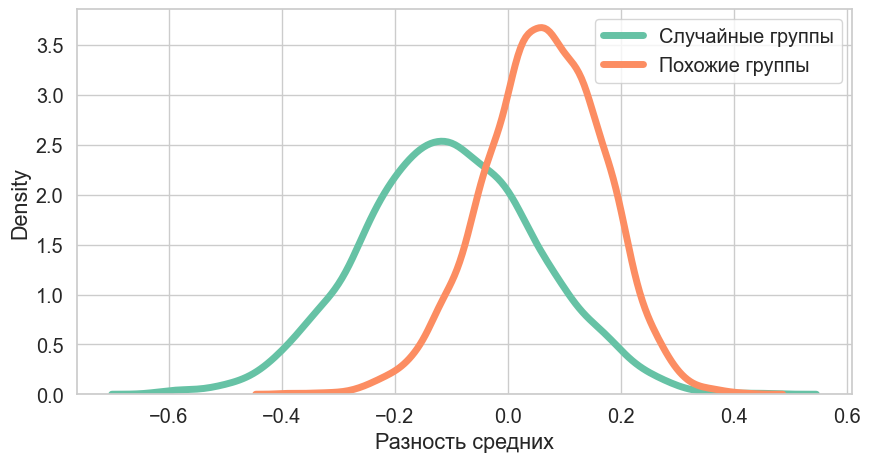

In [184]:
plt.figure(figsize=(10, 5))
sns.kdeplot(diffs_random, lw=5, label='Случайные группы')
sns.kdeplot(diffs_nearest, lw=5, label='Похожие группы')
plt.xlabel('Разность средних')
plt.legend();

Оценим теперь мощность при добавлении небольшого эффекта.

Сначала при случайном выборе групп

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:04<00:00, 1038.84it/s]


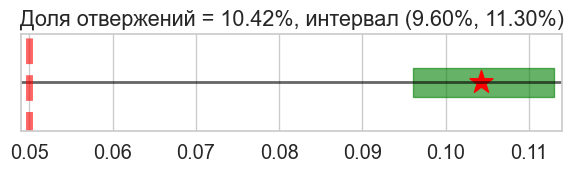

In [185]:
diffs_random = AA_test_selection(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    generate_sample=np.random.exponential,
    generate_indexes=random_indexes,
    n_iter=n_iter,
    sample_size=sample_size,
    effect=0.1
)

Теперь при выборе похожих групп

100%|██████████| 5000/5000 [00:22<00:00, 227.15it/s]


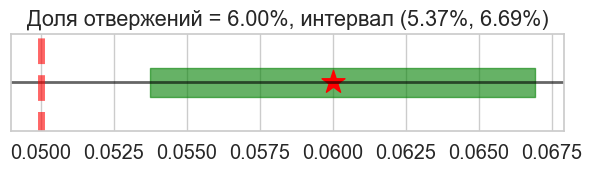

In [186]:
diffs_nearest = AA_test_selection(
    test=lambda x, y: sps.ttest_ind(x, y)[1] < alpha,
    generate_sample=np.random.exponential,
    generate_indexes=nearest_object_indexes,
    n_iter=n_iter,
    sample_size=sample_size,
    effect=0.1
)

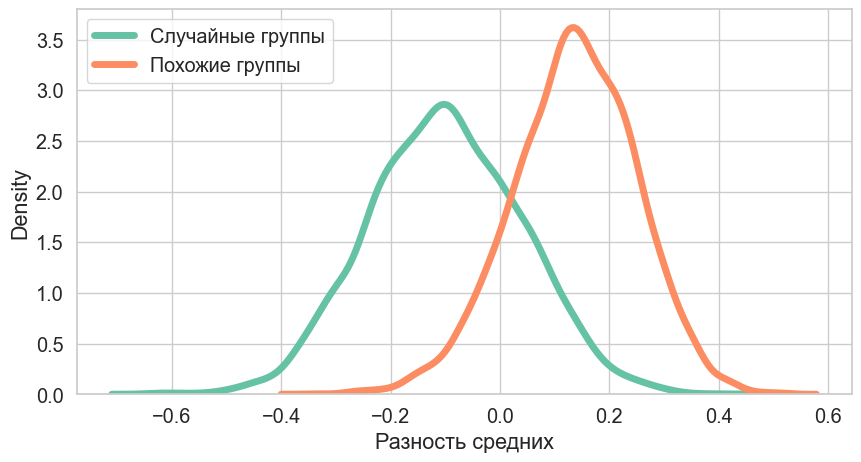

In [187]:
plt.figure(figsize=(10, 5))
sns.kdeplot(diffs_random, lw=5, label='Случайные группы')
sns.kdeplot(diffs_nearest, lw=5, label='Похожие группы')
plt.xlabel('Разность средних')
plt.legend();

Почему ничего не вышло с мощностью?

&nbsp;


&nbsp;


&nbsp;


&nbsp;


Дело в том, что выборки уже стали зависимы, а мы применили t-test для независимых выборок, по сути учитывая разброс данных в двойном объеме.

Поэтому при выборе похожих групп необходимо применять t-test для связных выборок. Провалидируем его

100%|██████████| 5000/5000 [00:21<00:00, 230.38it/s]


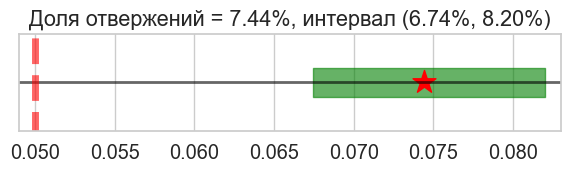

In [193]:
diffs_nearest = AA_test_selection(
    test=lambda x, y: sps.ttest_rel(x, y)[1] < alpha,
    generate_sample=np.random.exponential,
    generate_indexes=nearest_object_indexes,
    n_iter=n_iter,
    sample_size=sample_size
)

Оценим мощность

100%|██████████| 5000/5000 [00:39<00:00, 125.66it/s]


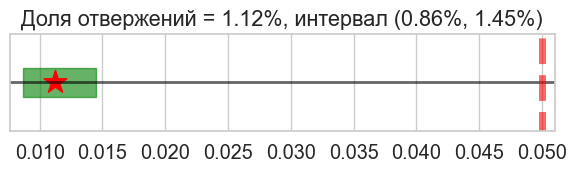

In [194]:
diffs_nearest = AA_test_selection(
    test=lambda x, y: sps.ttest_rel(x, y)[1] < alpha,
    generate_sample=np.random.exponential,
    generate_indexes=nearest_object_indexes,
    n_iter=n_iter,
    sample_size=sample_size,
    effect=0.1
)

Теперь видим, что получилось круто.